# Faster RCNN implementation for radar

## Imports

In [83]:
import os
import cv2
import glob
import time
import json
import torch
import pickle
import random
import torchvision
import numpy as np
from tqdm import tqdm
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from torchvision import models, transforms
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

## Import config info 

In [84]:
def load_config(config_path):
    with open(config_path, 'r') as config_file:
        content = config_file.read()
        if not content.strip():
            raise ValueError("Configuration file is empty")
        config = json.loads(content)
    return config


config_path = "/home/hawk/Desktop/objectDetection/Object_detection/configs/config.json"
config = load_config(config_path)

## Load RADDet data

In [85]:
# Define folder paths
RAD_folder_path = config["RAD_folder_path"]
stereo_folder_path = config["stereo_folder_path"]
GT_folder_path = config["GT_folder_path"]

# Numpy files
all_RAD_files = os.listdir(RAD_folder_path)
RAD_files = [file for file in all_RAD_files if file.endswith('.npy')]
RAD_files_paths = [os.path.join(RAD_folder_path, file) for file in RAD_files]

# Ground truth files
all_GT_files = os.listdir(GT_folder_path)
GT_files = [file for file in all_GT_files if file.endswith('.pickle')]
GT_files_paths = [os.path.join(GT_folder_path, file) for file in all_GT_files]

# Stereo image files
all_stereo_files = os.listdir(stereo_folder_path)
stereo_files = [file for file in all_stereo_files if file.endswith('.jpg')]
stereo_files_paths = [os.path.join(stereo_folder_path, file) for file in all_stereo_files]

all_loaded_RAD_files = []
for file in RAD_files_paths:
    loaded_file = np.load(file)
    all_loaded_RAD_files.append(loaded_file)
print(' ---- RAD ----')
print(f'number of RAD files loaded: {len(all_loaded_RAD_files)}')
print(f'each RAD file is of size: {all_loaded_RAD_files[0].shape} which stands for: (Range, Azimuth, Doppler)')
print('\n')

all_loaded_GT_files = []
for file in GT_files_paths:
    with open(file, 'rb') as f:  
        ground_truth = pickle.load(f) 
    all_loaded_GT_files.append(ground_truth)
print(' ---- GT ----')
print(f'number of GT files loaded: {len(all_loaded_GT_files)}')
print(f'each GT file is a dict with length 3: classes, boxes and cart_boxes. an example:')
print(all_loaded_GT_files[0])
print('\n')

all_loaded_stereo_files = []
for jpg_file in stereo_files_paths:
    img = Image.open(jpg_file)
    img = img.convert('RGB')
    all_loaded_stereo_files.append(img)
print(' ---- Stereo ----')
print(f"Number of loaded images: {len(all_loaded_stereo_files)}")

 ---- RAD ----
number of RAD files loaded: 126
each RAD file is of size: (256, 256, 64) which stands for: (Range, Azimuth, Doppler)


 ---- GT ----
number of GT files loaded: 126
each GT file is a dict with length 3: classes, boxes and cart_boxes. an example:
{'classes': ['truck', 'car', 'car', 'car'], 'boxes': array([[177.5, 173. ,  30. ,  28. ,  51. ,  25. ],
       [202. , 217.5,  32. ,   9. ,  34. ,  17. ],
       [ 66. ,  95. ,  40.5,   5. ,   7. ,   4. ],
       [ 15.5,  89.5,  38. ,   4. ,   8. ,   5. ]]), 'cart_boxes': array([[183.5, 283.5,  30. ,  30. ],
       [218. , 290.5,  19. ,  10. ],
       [ 72.5, 206. ,   6. ,  11. ],
       [ 26.5, 183. ,   8. ,  13. ]])}


 ---- Stereo ----
Number of loaded images: 126


## Create a custom RADDet dataset 

In [86]:
def readAndEncodeGtRD(gt_instance, rd_shape):
    x_shape, y_shape = rd_shape[1], rd_shape[0]
    boxes = gt_instance["boxes"]
    classes = gt_instance["classes"]
    new_boxes = []
    new_classes = []
    for (box, class_) in zip(boxes, classes):
        yc, xc, h, w = box[0], box[2], box[3], box[5]
        y1, y2, x1, x2 = int(yc - h / 2), int(yc + h / 2), int(xc - w / 2), int(xc + w / 2)
        if x1 < 0:
            x1 += x_shape
            box1 = [y1 , x1, y2, x_shape]
            box2 = [y1, 0, y2, x2]
            new_boxes.append(box1)
            new_classes.append(class_)
            new_boxes.append(box2)
            new_classes.append(class_)
        elif x2 >= x_shape:
            x2 -= x_shape
            box1 = [y1, x1, y2, x_shape]
            box2 = [y1, 0, y2, x2]
            new_boxes.append(box1)
            new_classes.append(class_)
            new_boxes.append(box2)
            new_classes.append(class_)
        else:
            new_boxes.append([y1 , x1, y2 , x2])
            new_classes.append(class_)
    return new_boxes, new_classes

In [87]:
def complexTo2channels(target_array):
    assert target_array.dtype == np.complex64
    output_array = getMagnitude(target_array)
    output_array = getLog(output_array)
    return output_array

def getMagnitude(target_array, power_order=2):
    target_array = np.abs(target_array)
    target_array = pow(target_array, power_order)
    return target_array

def getLog(target_array, scalar=1., log_10=True):
    if log_10:
        return scalar * np.log10(target_array + 1.)
    else:
        return target_array

def getSumDim(target_array, target_axis):
    output = np.sum(target_array, axis=target_axis)
    return output

In [88]:
class RaddetDataset(Dataset):
    """Custom Dataset for RADDet dataset."""
    
    def __init__(self, RAD_files, GT_files, stereo_files, transform=None):
        self.transform = transform
        self.classes_list = ["person", "bicycle", "car", "motorcycle", "bus", "truck"]
        self.RAD_maps = RAD_files
        self.GT_data = GT_files
        self.stereo_data = stereo_files
        self.global_mean_log = 3.2438383
        self.global_variance_log = 6.8367246
        self.global_max_log = 10.0805629
        self.global_min_log = 0.0
    
    def __len__(self):
        return len(self.RAD_maps)
    
    def __getitem__(self, idx):
        RAD_complex = self.RAD_maps[idx]
        
        RAD_data = complexTo2channels(RAD_complex)
        RAD_data = (RAD_data - self.global_mean_log) / self.global_variance_log
        
        gt_instances = self.GT_data[idx]

        RD_data = getSumDim(RAD_data, target_axis=1)

        bboxes, classes = readAndEncodeGtRD(gt_instances, RD_data.shape)
        #seq_id = int(RAD_filename.split('/')[-2].split('_')[-1])
        
        objects = []
        for box, class_ in zip(bboxes, classes):
            ymin, xmin, ymax, xmax = box
            area = (xmax - xmin) * (ymax - ymin)
            objects.append({
                'bbox': [ymin, xmin, ymax, xmax],
                'label': self.classes_list.index(class_),
                'area': area,
            })
        
        image_filename = self.stereo_data[idx]
        image = plt.imread(image_filename)


        sample = {
            'spectrum': torch.tensor(RD_data, dtype=torch.float32),
            'image': image,
            'image_filename': image_filename,
            'objects': objects,
        }
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

RADDet Dataset Sample Details:


Sample spectrum shape: torch.Size([256, 64])
Image filename: /home/hawk/Desktop/data/Raddet/train/stereo_image/part_9/008608.jpg
Number of objects: 1
Object bbox: [198, 20, 203, 33], label: 0, area: 65


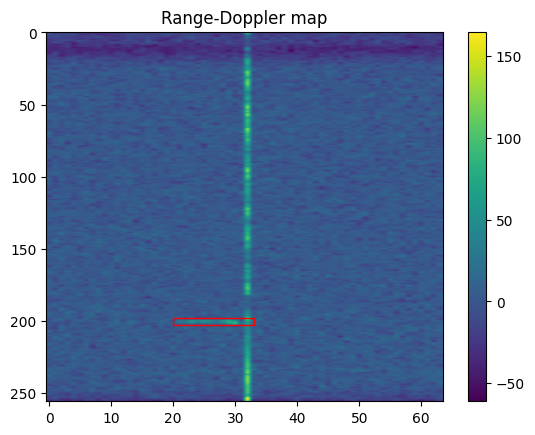

<function matplotlib.pyplot.show(close=None, block=None)>

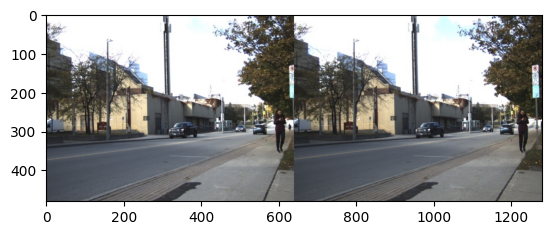

In [95]:
random_num = random.randint(0,100)
train_dataset = RaddetDataset(all_loaded_RAD_files, all_loaded_GT_files, stereo_files_paths)#all_loaded_stereo_files)
sample = train_dataset[random_num]

print("RADDet Dataset Sample Details:")
print("\n")
print(f'Sample spectrum shape: {sample["spectrum"].shape}')
print(f'Image filename: {sample["image_filename"]}')
print(f'Number of objects: {len(sample["objects"])}')
for obj in sample["objects"]:
    print(f'Object bbox: {obj["bbox"]}, label: {obj["label"]}, area: {obj["area"]}')

spectrum = sample['spectrum'].numpy()
plt.imshow(spectrum, aspect='auto', cmap='viridis')
plt.title('Range-Doppler map')
plt.colorbar()

for obj in sample["objects"]:

    bbox = obj["bbox"]
    ymin, xmin, ymax, xmax = bbox
    
    if xmin < 0 or ymin < 0 or xmax > spectrum.shape[1] or ymax > spectrum.shape[0]:
        print(f'Bounding box {bbox} is out of spectrum bounds.')
        continue

    rect = patches.Rectangle(
        (xmin, ymin), xmax - xmin, ymax - ymin,
        linewidth=1, edgecolor='r', facecolor='none'
    )
    plt.gca().add_patch(rect)

plt.show()
image_filename = sample['image_filename']
image = plt.imread(image_filename)
fig, ax = plt.subplots(1)
ax.imshow(image)
plt.show

## Train Faster R-CNN

In [90]:
def get_transform():
    def transform(sample):
        spectrum = sample['spectrum']
        image = sample['image']
        objects = sample['objects']
        
        image = F.to_tensor(image)
        return {'spectrum': spectrum, 'image': image, 'objects': objects}
    
    return transform
def is_valid_bbox(bbox):
    ymin, xmin, ymax, xmax = bbox
    return (xmax - xmin) > 0 and (ymax - ymin) > 0

train_dataset = RaddetDataset(all_loaded_RAD_files, all_loaded_GT_files, stereo_files_paths, transform=get_transform())
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: x)

def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

num_classes = len(train_dataset.classes_list) + 1
model = get_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    i = 0
    for samples in train_loader:
        images = list(sample['image'].to(device) for sample in samples)
        targets = []
        for sample in samples:
            d = {}
            valid_objects = [obj for obj in sample['objects'] if is_valid_bbox(obj['bbox'])]
            if len(valid_objects) == 0:
                continue
            d['boxes'] = torch.tensor([obj['bbox'] for obj in valid_objects], dtype=torch.float32).to(device)
            d['labels'] = torch.tensor([obj['label'] for obj in valid_objects], dtype=torch.int64).to(device)
            targets.append(d)
        
        if len(targets) == 0:
            continue

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        print(f'Epoch {epoch+1}, Iteration {i+1}, Loss: {losses.item()}')
        i += 1
    
    lr_scheduler.step()

print("Training complete!")


/home/hawk/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hawk/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1, Iteration 1, Loss: 3.5966711044311523
Epoch 1, Iteration 2, Loss: 4.208014965057373
Epoch 1, Iteration 3, Loss: 3.1229379177093506
Epoch 1, Iteration 4, Loss: 1.569953203201294
Epoch 1, Iteration 5, Loss: 0.9315094947814941
Epoch 1, Iteration 6, Loss: 1.2774596214294434
Epoch 1, Iteration 7, Loss: 1.461761474609375
Epoch 1, Iteration 8, Loss: 1.336150884628296
Epoch 1, Iteration 9, Loss: 1.2753169536590576
Epoch 1, Iteration 10, Loss: 1.096163272857666
Epoch 1, Iteration 11, Loss: 1.788040280342102
Epoch 1, Iteration 12, Loss: 1.1132709980010986
Epoch 1, Iteration 13, Loss: 1.6630831956863403
Epoch 1, Iteration 14, Loss: 1.6491761207580566
Epoch 1, Iteration 15, Loss: 1.6966962814331055
Epoch 1, Iteration 16, Loss: 1.411647081375122
Epoch 1, Iteration 17, Loss: 1.2940547466278076
Epoch 1, Iteration 18, Loss: 1.1427905559539795
Epoch 1, Iteration 19, Loss: 1.4945940971374512
Epoch 1, Iteration 20, Loss: 1.1445342302322388
Epoch 1, Iteration 21, Loss: 0.933895468711853
Epoch 1, 

KeyboardInterrupt: 

## Inference

/tmp/ipykernel_688603/2169063117.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spectrum_tensor = torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # Shape: [1, 1, 256, 64]


[{'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([])}]
Raw boxes: []
Raw labels: []
Raw scores: []
Filtered boxes: []
Filtered labels: []
Filtered scores: []


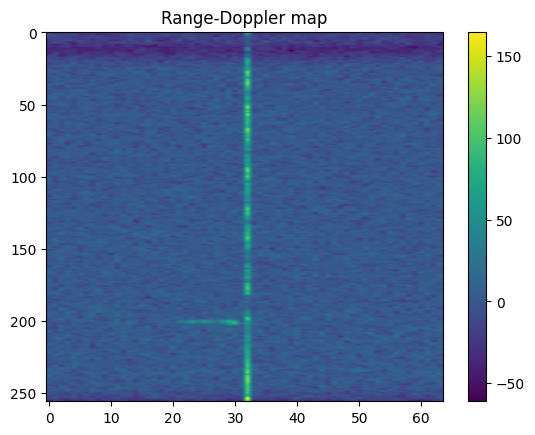

In [100]:
model.eval()

# Function to prepare spectrum tensor
def prepare_spectrum(spectrum):
    spectrum_tensor = torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # Shape: [1, 1, 256, 64]
    return spectrum_tensor

# Function to process predictions
def process_predictions(predictions, score_threshold=0):
    prediction = predictions[0]
    boxes = prediction['boxes'].cpu().numpy()
    labels = prediction['labels'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()
    
    # Print the raw values of boxes, labels, and scores
    print("Raw boxes:", boxes)
    print("Raw labels:", labels)
    print("Raw scores:", scores)
    
    # Filter predictions by score threshold
    filtered_boxes = boxes[scores >= score_threshold]
    filtered_labels = labels[scores >= score_threshold]
    filtered_scores = scores[scores >= score_threshold]
    
    # Print filtered values
    print("Filtered boxes:", filtered_boxes)
    print("Filtered labels:", filtered_labels)
    print("Filtered scores:", filtered_scores)
    
    return filtered_boxes, filtered_labels, filtered_scores

# Function to visualize spectrum and predictions
def visualize_spectrum_predictions(spectrum, boxes, labels, scores):
    plt.imshow(spectrum, aspect='auto', cmap='viridis')
    plt.title('Range-Doppler map')
    plt.colorbar()
    
    ax = plt.gca()
    for box, label, score in zip(boxes, labels, scores):
        ymin, xmin, ymax, xmax = box
        width, height = xmax - xmin, ymax - ymin
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin, f'{label}: {score:.2f}', bbox=dict(facecolor='yellow', alpha=0.5))
    
    plt.show()

# Example usage
spectrum_tensor = prepare_spectrum(sample['spectrum'])

# Perform inference
with torch.no_grad():
    predictions = model(spectrum_tensor)
print(predictions)
# Process and visualize predictions
boxes, labels, scores = process_predictions(predictions)
visualize_spectrum_predictions(sample['spectrum'].numpy(), boxes, labels, scores)
